# "Cross-validation with multiple likelihoods"
> Alternative models and diagrams for EABM section on model comparison

- toc: true 
- author: Oriol Abril Pla
- badges: true
- categories: [arviz, model comparison]

In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
import theano.tensor as tt
import xarray as xr

rng = np.random.default_rng(10)

In [2]:
az.style.use("arviz-darkgrid")
plt.rcParams["image.cmap"] = "Dark2"
plt.rcParams["axes.grid"] = False
plt.rcParams["xtick.labelbottom"] = False
plt.rcParams["font.size"] = plt.rcParams["ytick.labelsize"]

## Data preprocessing

In [3]:
df_all = pd.read_csv("data/18-19_table.txt", sep="\t", comment="#")
team_names = df_all["Home \ Away "].str.strip().copy(deep=True).values
team_abbrs = df_all.columns.str.strip().copy(deep=True).values[1:]
df_all = df_all.melt(id_vars=["Home \ Away "])
df_all.columns = ["home_team", "away_team", "result"]
df_all = df_all.apply(lambda x: x.str.strip(), axis="index")
df_all = df_all.replace(
    {
        "away_team": {abbr: team for abbr, team in zip(team_abbrs, team_names)},
        "result": {"—": np.nan}
    }
).dropna(subset=["result"]).reset_index(drop=True)
df_aux = df_all.result.str.split("–", expand=True).astype(int)
df_aux.columns = ["home_goals", "away_goals"]
df_matches = pd.concat((df_all[["home_team", "away_team"]], df_aux), axis="columns")
#df_matches.to_csv("18-19_df.csv", index=False)

In [4]:
reorder_idx = np.arange(len(df_matches))
rng.shuffle(reorder_idx)
df_matches = df_matches.loc[reorder_idx]

## Helpers for diagram generation

In [5]:
n_matches = len(df_matches)
home_goal_ary = df_matches.home_goals.values
away_goal_ary = df_matches.away_goals.values
home_team_ary = df_matches.home_team.values
away_team_ary = df_matches.away_team.values
teams = np.unique(df_matches.home_team)

In [6]:
def plot_cv_matrix(cv_mat, ax, ticks=False):
    n_rows = cv_mat.shape[0]
    rows = np.arange(n_rows)
    ax.imshow(cv_mat, vmax=9, alpha=.5)
    
    # annotate results
    for row in rows:
        ax.annotate(f"{home_goal_ary[row]:.0f}", (0, row), va="center", ha="center")
        ax.annotate(f"{away_goal_ary[row]:.0f}", (1, row), va="center", ha="center")
    
    # annotate teams
    if ticks:
        ax.set_yticks(rows)
        ax.set_yticklabels(home_team_ary)
        away_axis = ax.secondary_yaxis("right")
        away_axis.set_yticks(rows)
        away_axis.set_yticklabels(away_team_ary);
    else:
        ax.set_axis_off()

In [7]:
def get_loo_match_matrix(idx):
    cv_matrix = np.ones((n_matches, 2))
    cv_matrix[idx, :] = 2
    return cv_matrix

def get_loo_away_matrix(idx):
    cv_matrix = np.ones((n_matches, 2))
    cv_matrix[:, 0] = 8
    cv_matrix[idx, 1] = 2
    return cv_matrix

def get_loo_goals_matrix(idx):
    cv_matrix = np.ones((n_matches, 2))
    row_idx, col_idx = np.divmod(idx, 2)
    cv_matrix[row_idx, col_idx] = 2
    return cv_matrix

def get_loo_team_matrix(idx):
    """If team excluded, exclude whole match!"""
    cv_matrix = np.ones((n_matches, 2))
    team_i = pd.unique(away_team_ary)[idx]
    mask = (home_team_ary == team_i) | (away_team_ary == team_i)
    cv_matrix[mask, :] = 2
    return cv_matrix

## Base model

In [8]:
coords = {"team": team_names, "match": np.arange(len(df_matches))}
home_team_idxs, team_names = pd.factorize(df_matches.home_team, sort=True)
away_team_idxs, _ = pd.factorize(df_matches.away_team, sort=True)
num_teams = len(team_names)

In [9]:
with pm.Model(coords=coords) as m_base:
    # constant data
    home_team = pm.Data("home_team", home_team_idxs, dims="match")
    away_team = pm.Data("away_team", away_team_idxs, dims="match")
    
    # global model parameters
    home = pm.Normal('home', mu=0, sigma=5)
    sd_att = pm.HalfStudentT('sd_att', nu=3, sigma=2.5)
    sd_def = pm.HalfStudentT('sd_def', nu=3, sigma=2.5)
    intercept = pm.Normal('intercept', mu=0, sigma=5)

    # team-specific model parameters
    atts_star = pm.Normal("atts_star", mu=0, sigma=sd_att, dims="team")
    defs_star = pm.Normal("defs_star", mu=0, sigma=sd_def, dims="team")

    atts = atts_star - tt.mean(atts_star)
    defs = defs_star - tt.mean(defs_star)
    home_theta = tt.exp(intercept + home + atts[home_team] + defs[away_team])
    away_theta = tt.exp(intercept + atts[away_team] + defs[home_team])

    # likelihood of observed data
    home_goals = pm.Poisson('home_goals', mu=home_theta, observed=df_matches.home_goals, dims="match")
    away_goals = pm.Poisson('away_goals', mu=away_theta, observed=df_matches.away_goals, dims="match")

In [10]:
with m_base:
    idata_base = pm.sample(random_seed=1375, return_inferencedata=True)

# define helpers to make code less verbose
log_lik = idata_base.log_likelihood
const = idata_base.constant_data

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [defs_star, atts_star, intercept, sd_def, sd_att, home]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 6 seconds.


## Leave one match out CV

In [11]:
n_rows = 10
n_cols = 7
figsize = (8, 2.55)

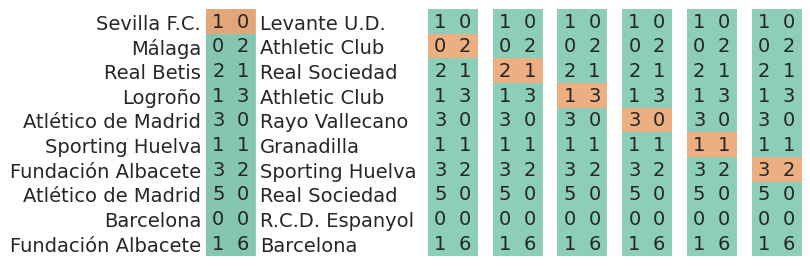

In [12]:
#hide_output
fig, axes = plt.subplots(1, n_cols, figsize=figsize, constrained_layout=True)

for i in range(n_cols):
    cv_mat_i = get_loo_match_matrix(i)
    plot_cv_matrix(cv_mat_i[:10], axes[i], ticks=i==0)
#fig.savefig("cv_match.png")

In [13]:
with pm.Model(coords=coords) as m_match:
    # constant data
    home_team = pm.Data("home_team", home_team_idxs, dims="match")
    away_team = pm.Data("away_team", away_team_idxs, dims="match")
    
    # global model parameters
    home = pm.Normal('home', mu=0, sigma=5)
    sd_att = pm.HalfStudentT('sd_att', nu=3, sigma=2.5)
    sd_def = pm.HalfStudentT('sd_def', nu=3, sigma=2.5)
    intercept = pm.Normal('intercept', mu=0, sigma=5)

    # team-specific model parameters
    atts_star = pm.Normal("atts_star", mu=0, sigma=sd_att, dims="team")
    defs_star = pm.Normal("defs_star", mu=0, sigma=sd_def, dims="team")

    atts = atts_star - tt.mean(atts_star)
    defs = defs_star - tt.mean(defs_star)
    home_theta = tt.exp(intercept + home + atts[home_team] + defs[away_team])
    away_theta = tt.exp(intercept + atts[away_team] + defs[home_team])

    # alternative likelihood of observed data
    def double_poisson(home_goals, away_goals):
        return (
            pm.Poisson.dist(mu=home_theta).logp(home_goals) + 
            pm.Poisson.dist(mu=away_theta).logp(away_goals)
        )
    
    matches = pm.DensityDist('matches', double_poisson, observed={
        'home_goals': df_matches.home_goals, 'away_goals': df_matches.away_goals
    })

In [14]:
with m_match:
    idata_match = pm.sample(
        random_seed=1375, tune=1500, return_inferencedata=True
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [defs_star, atts_star, intercept, sd_def, sd_att, home]


Sampling 4 chains for 1_500 tune and 1_000 draw iterations (6_000 + 4_000 draws total) took 6 seconds.


In [15]:
az.loo(idata_match)

Computed from 4000 by 240 log-likelihood matrix

         Estimate       SE
elpd_loo  -716.68    15.85
p_loo       27.60        -

The scale is now log by default. Use 'scale' argument or 'stats.ic_scale' rcParam if
you rely on a specific value.
A higher log-score (or a lower deviance) indicates a model with better predictive
accuracy.

## Leave away out CV

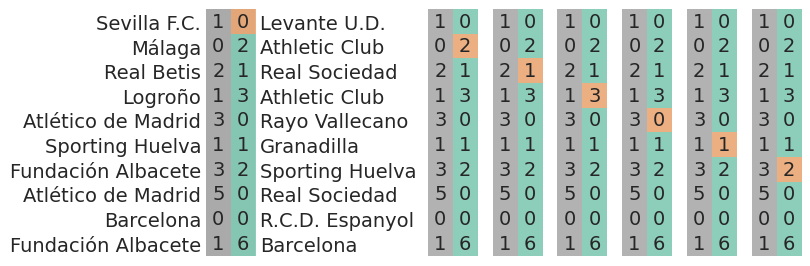

In [16]:
#hide_output
fig, axes = plt.subplots(1, n_cols, figsize=figsize, constrained_layout=True)

for i in range(n_cols):
    cv_mat_i = get_loo_away_matrix(i)
    plot_cv_matrix(cv_mat_i[:10], axes[i], ticks=i==0)
#fig.savefig("cv_away.png")

##### Alternative implementation 
Here there is an example of an alternative implementation of the same model, but targeted to this specific predictive task. Notice how we do not throw away the info provided by `away_goals`, we simply modify how it is taken into account to make it clear we do not care about predicting these values.

In [17]:
with pm.Model(coords=coords) as m_away:
    home_team = pm.Data("home_team", home_team_idxs, dims="match")
    away_team = pm.Data("away_team", away_team_idxs, dims="match")
    
    home = pm.Normal('home', mu=0, sigma=5)
    sd_att = pm.HalfStudentT('sd_att', nu=3, sigma=2.5)
    sd_def = pm.HalfStudentT('sd_def', nu=3, sigma=2.5)
    intercept = pm.Normal('intercept', mu=0, sigma=5)
    atts_star = pm.Normal("atts_star", mu=0, sigma=sd_att, dims="team")
    defs_star = pm.Normal("defs_star", mu=0, sigma=sd_def, dims="team")

    atts = atts_star - tt.mean(atts_star)
    defs = defs_star - tt.mean(defs_star)
    home_theta = tt.exp(intercept + home + atts[home_team] + defs[away_team])
    away_theta = tt.exp(intercept + atts[away_team] + defs[home_team])
    
    pm.Potential("home_goals", pm.Poisson.dist(mu=home_theta).logp(df_matches.home_goals.values))
    away_goals = pm.Poisson('away_goals', mu=away_theta, observed=df_matches.away_goals, dims="match")

In [18]:
with m_away:
    # use different seed, same one gives exactly the same result
    idata_home = pm.sample(random_seed=1374, return_inferencedata=True) 

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [defs_star, atts_star, intercept, sd_def, sd_att, home]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 7 seconds.


In [19]:
az.loo(idata_home)

Computed from 4000 by 240 log-likelihood matrix

         Estimate       SE
elpd_loo  -344.22    12.94
p_loo       12.53        -

The scale is now log by default. Use 'scale' argument or 'stats.ic_scale' rcParam if
you rely on a specific value.
A higher log-score (or a lower deviance) indicates a model with better predictive
accuracy.

## Leave one "scored goals per match and per team" out CV

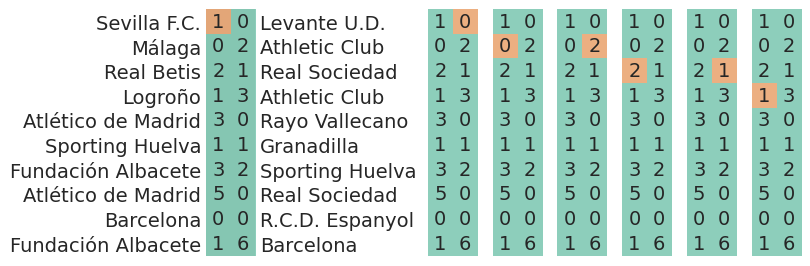

In [20]:
#hide_output
fig, axes = plt.subplots(1, n_cols, figsize=figsize, constrained_layout=True)

for i in range(n_cols):
    cv_mat_i = get_loo_goals_matrix(i)
    plot_cv_matrix(cv_mat_i[:10], axes[i], ticks=i==0)
#fig.savefig("cv_any_goals.png")

##### Alternative implementation

<div class="alert alert-info">

**Note:** There is a simpler implementation which is basically identical to the base one but assuming a single observation which is therefore a matrix with $n$ rows and 2 columns. However, I think this makes a better job to highlight the differences between the different cases.

</div>

In [21]:
df_home = df_matches[["home_team", "away_team", "home_goals"]].rename(columns={"home_goals": "goals"})
df_home["visitor"] = 0
df_away = df_matches[["home_team", "away_team", "away_goals"]].rename(columns={"away_goals": "goals"})
df_away["visitor"] = 1
df_goals = pd.concat((df_home, df_away), axis="index")

coords["idx"] = np.arange(len(df_goals))
with pm.Model(coords=coords) as m_goals:
    # constant data
    home_team = pm.Data(
        "home_team", pd.factorize(df_goals.home_team, sort=True)[0], dims="idx"
    )
    away_team = pm.Data(
        "away_team", pd.factorize(df_goals.away_team, sort=True)[0], dims="idx"
    )
    is_visitor = pm.Data("is_visitor", df_goals.visitor, dims="idx")
    
    # global model parameters
    home = pm.Normal('home', mu=0, sigma=5)
    sd_att = pm.HalfStudentT('sd_att', nu=3, sigma=2.5)
    sd_def = pm.HalfStudentT('sd_def', nu=3, sigma=2.5)
    intercept = pm.Normal('intercept', mu=0, sigma=5)

    # team-specific model parameters
    atts_star = pm.Normal("atts_star", mu=0, sigma=sd_att, dims="team")
    defs_star = pm.Normal("defs_star", mu=0, sigma=sd_def, dims="team")

    atts = atts_star - tt.mean(atts_star)
    defs = defs_star - tt.mean(defs_star)
    home_aux = tt.stack([home, 0])
    pars_aux = tt.stack([defs, atts])
    theta = tt.exp(
        intercept + home_aux[is_visitor] + pars_aux[(is_visitor, away_team)] + pars_aux[(1-is_visitor, home_team)]
    )

    # alternative likelihood of observed data
    goals = pm.Poisson('goals', mu=theta, observed=df_goals.goals, dims="idx")

/home/oriol/venvs/arviz-dev/lib/python3.6/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/home/oriol/venvs/arviz-dev/lib/python3.6/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


In [22]:
with m_goals:
    idata_goals = pm.sample(random_seed=1375, tune=1500, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/home/oriol/venvs/arviz-dev/lib/python3.6/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [defs_star, atts_star, intercept, sd_def, sd_att, home]


Sampling 4 chains for 1_500 tune and 1_000 draw iterations (6_000 + 4_000 draws total) took 11 seconds.
/home/oriol/venvs/arviz-dev/lib/python3.6/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


In [23]:
az.loo(idata_goals)

Computed from 4000 by 480 log-likelihood matrix

         Estimate       SE
elpd_loo  -716.68    17.43
p_loo       27.69        -

The scale is now log by default. Use 'scale' argument or 'stats.ic_scale' rcParam if
you rely on a specific value.
A higher log-score (or a lower deviance) indicates a model with better predictive
accuracy.

## Leave one team out CV

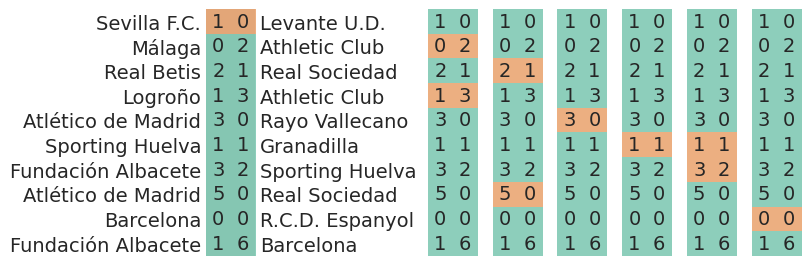

In [24]:
#hide_output
fig, axes = plt.subplots(1, n_cols, figsize=figsize, constrained_layout=True)

for i in range(n_cols):
    cv_mat_i = get_loo_team_matrix(i)
    plot_cv_matrix(cv_mat_i[:10], axes[i], ticks=i==0)
#fig.savefig("cv_team.png")

## Sanity check
Let's check that all models are indeed the same and we are only changing the definition of _observation_

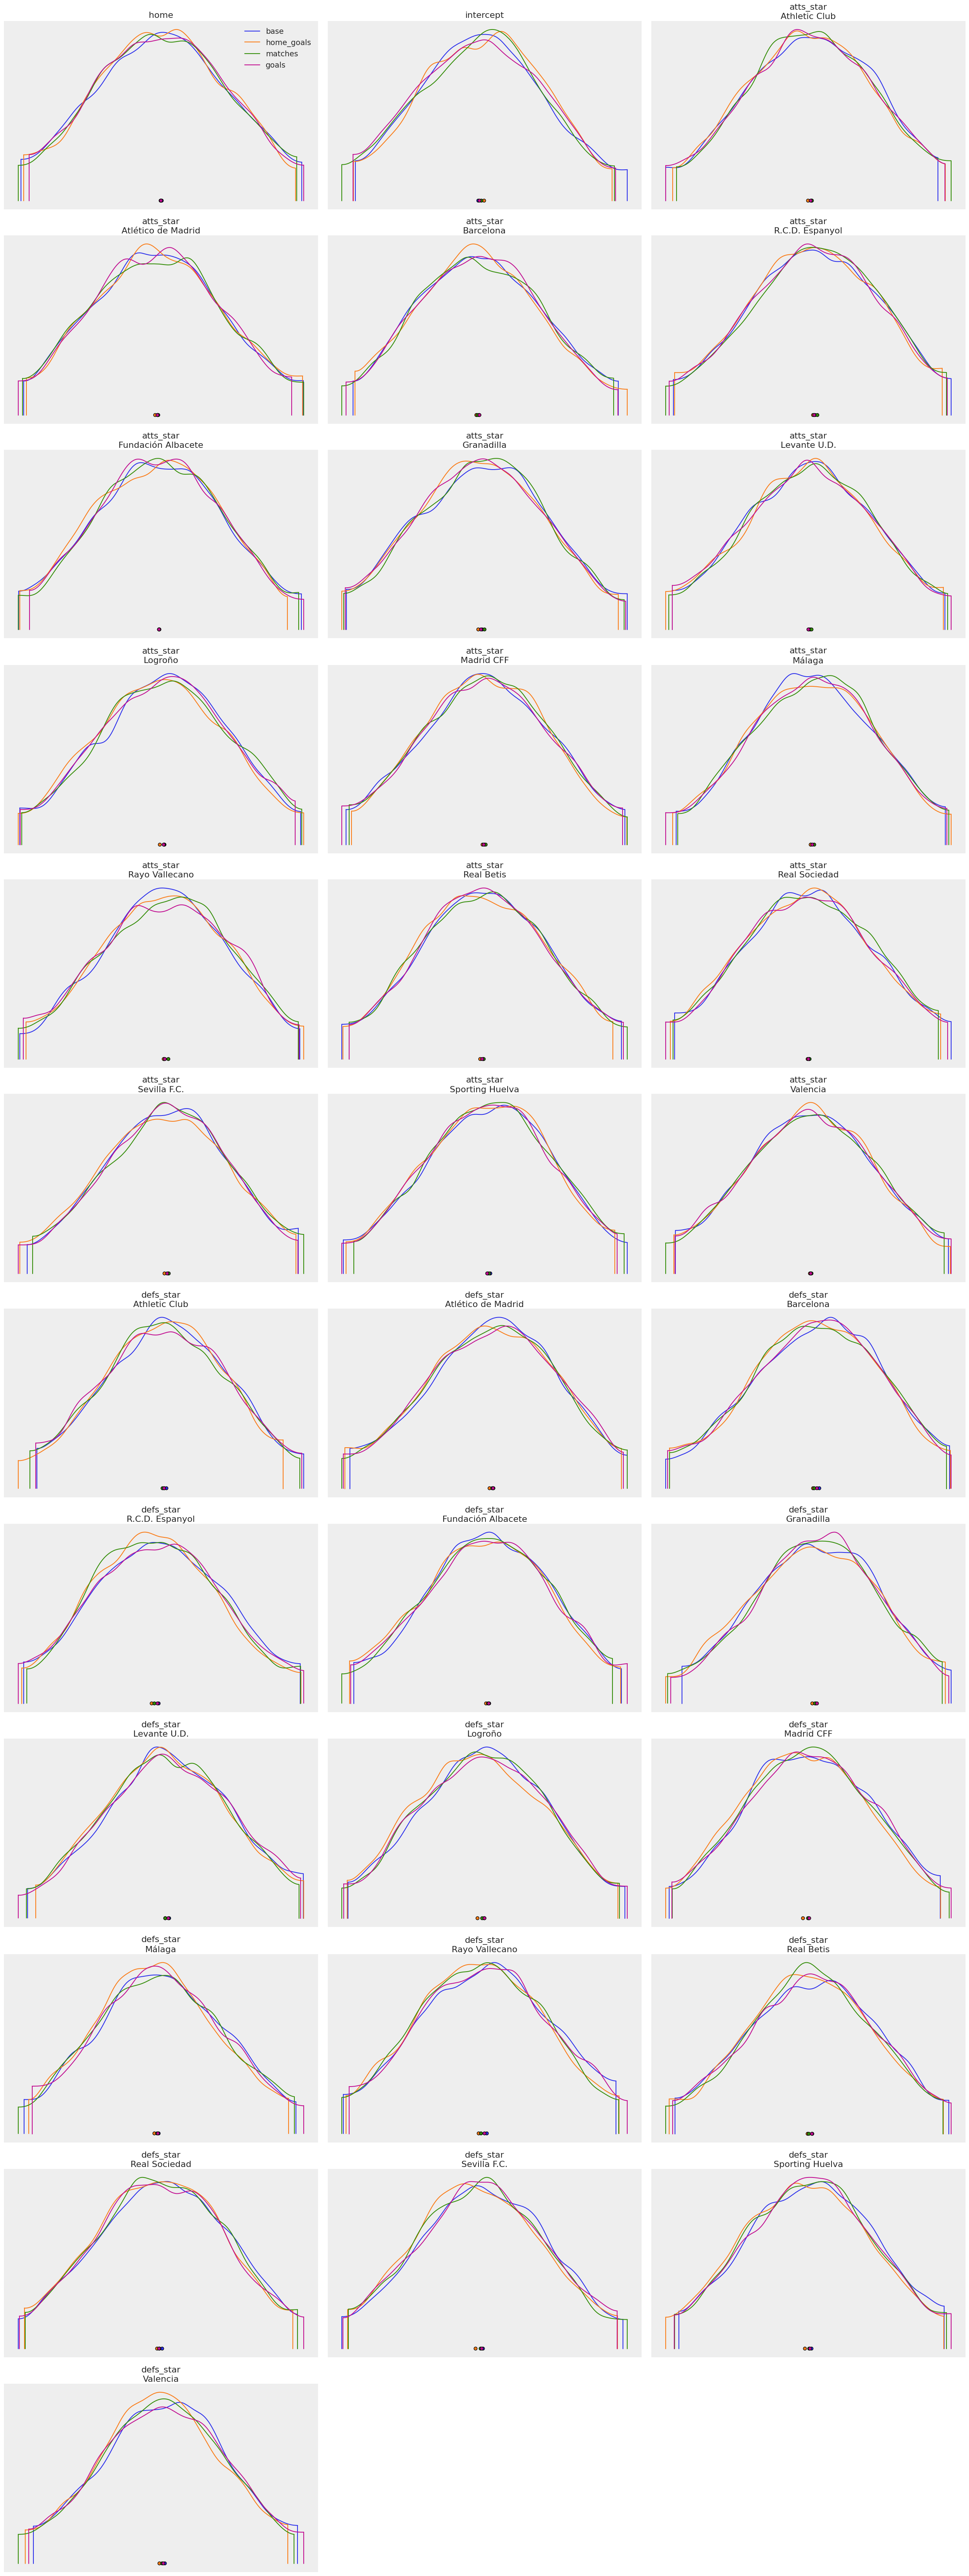

In [25]:
with az.rc_context({"plot.max_subplots": 50}):
    az.plot_density(
        (idata_base, idata_home, idata_match, idata_goals), 
        data_labels=("base", "home_goals", "matches", "goals"),
        var_names=["home", "intercept", "atts_star", "defs_star"]
        
    );